# W207 Final Project: Internet Advertisements
Maria Corina Cabezas, Dean Wang, Angel Chen 

## Background

The project seeks to investigate the topic of Internet Advertisements with the goal of using Machine Learning algortihms to predict whether an image is an advertisement ("ad") or not ("non-ad"). An effective ad-identification algorithm could help with spam filtering in e-mails and other messages (SMS, social media, etc.). It can also be applied to website ad blocking for a better internet browsing experience. 

The Internet Advertisement dataset used in this analysis comes from the UCI Machine Learning Repository. It represents a set of possible advertisements on Internet pages. The features encode the geometry of the image (if available) as well as phrases occuring in the URL, the image's URL and alt text, the anchor text, and words occurring near the anchor text. 

The full dataset can be downloaded and viewed here: https://archive.ics.uci.edu/ml/datasets/Internet+Advertisements.

### Prerequisite Libraries

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import model_selection

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

## Data Exploration & Analysis

Before any modeling effort commences, we first looked through the dataset in order to have some basic understanding of what the rows and columns represent. This data exploration step helps us to gain intuition about features we can use in subsequent analysis. 

### Data Cleaning

Here we loaded the dataset into the variable `df` and added in column names. There are a total of 3,279 data points and 1,559 attritubes per entry. Based on the documentation of the dataset, 3 out of the 1,559 columns are continuous while the rest are binary. However not every data point has a complete set of 1,559 attributes. Some contain missing values for one or more of the 3 continuous columns. We replaced `?` with proper missing value representation - `NAN` - for these column values.

In [2]:
# Load the dataset
df = pd.read_csv('ad.data', header = None)

In [3]:
# Load column names
names = []
with open("ad.names", encoding="ISO-8859-1") as file:
    for line in file:
        if ":" in line and "|" not in line:
            names.append(line[:line.index(":")])
            
names.append("class")

In [4]:
# Format column values as integers
df.columns = df.columns.astype('int')

In [5]:
# Get basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Columns: 1559 entries, 0 to 1558
dtypes: int64(1554), object(5)
memory usage: 39.0+ MB


In [6]:
# Cleaning
# We would like to replace missing values and "?" values in the first four columns which contain
# missing values
def replace_missing(df):
    for i in df:
        df[i]=df[i].replace('[?]',np.NAN,regex=True).astype('float')
        df[i]=df[i].fillna(df[i].mean())
    return df

df[[0,1,2,3]]=replace_missing(df.iloc[:,[0,1,2,3]].copy()).values

In [7]:
df.columns = names

In [8]:
# Data distribution for the 3 continuous variables
df[names[:3]].describe()

,height,width,aratio
count,3279.000000,3279.000000,3279.000000
mean,64.021886,155.344828,3.911953
std,46.703695,110.729038,5.136153
min,1.000000,1.000000,0.001500
25%,32.500000,90.000000,1.279400
50%,64.021886,150.000000,3.911953
75%,64.021886,155.344828,3.911953
max,640.000000,640.000000,60.000000


### Data Analysis

After data cleaning, we conducted more in depth analysis of some of the interesting features in the dataset, namely the 3 continuous columns `height`, `width`, `aratio`, and the label `class`. Values of `height` and `width` represent the dimension of the image while `aratio` describes the aspect ratio. `class` is the label of the data point denoting whether or not that particular image is "ad" or "non-ad". We plotted below the distribution of "ad" and "non-ad" data points as well as the boxplots of 3 continuous variables for the 2 class type.

In [9]:
df.head()

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,class
0,125.0,125.0,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33.0,230.0,6.9696,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


nonad.    2820
ad.        459
Name: class, dtype: int64

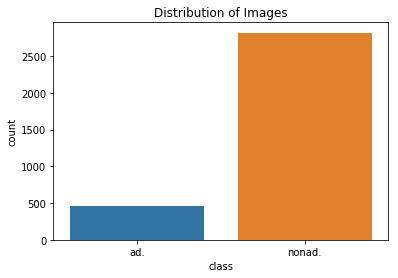

In [10]:
# Class Distribution
sns.countplot(df['class'])
plt.title('Distribution of Images')
df['class'].value_counts()

Here we can observe the data is not equally distributed among the 2 classes. Over 88% of the examples are Non-Ads.

Text(0, 0.5, 'Width')

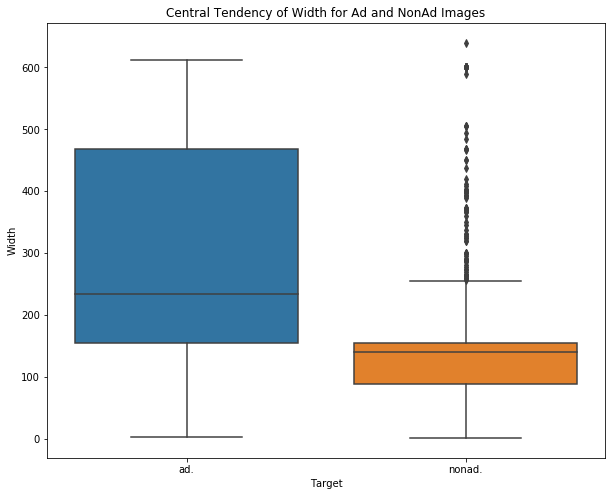

In [11]:
# Central tendency of width for each target
plt.figure(figsize=(10,8))
sns.boxplot(x = 'class',y = 'width', data = df)
plt.title('Central Tendency of Width for Ad and NonAd Images')
plt.xlabel('Target')
plt.ylabel('Width')

This graph shows how the central tendency of width differs over the two classes: Ad images tend to have a higher width between 150 - 500 cm while Non-Ad images tend to be smaller in width averaging over 80 - 150 cm.

Text(0, 0.5, 'Height')

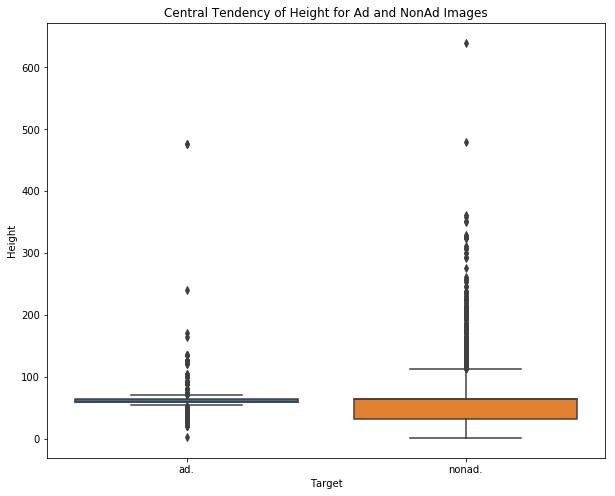

In [12]:
# Central Tendency of Height for each target
plt.figure(figsize=(10,8))
sns.boxplot(x = 'class',y = 'height', data = df)
plt.title('Central Tendency of Height for Ad and NonAd Images')
plt.xlabel('Target')
plt.ylabel('Height')

When it comes to height, the difference is not as big as with width; We can see that Ad images tend to be around 60-65 cm while Non-Ad images have a wider height range of 40-60 cm.

Text(0, 0.5, 'Ratio')

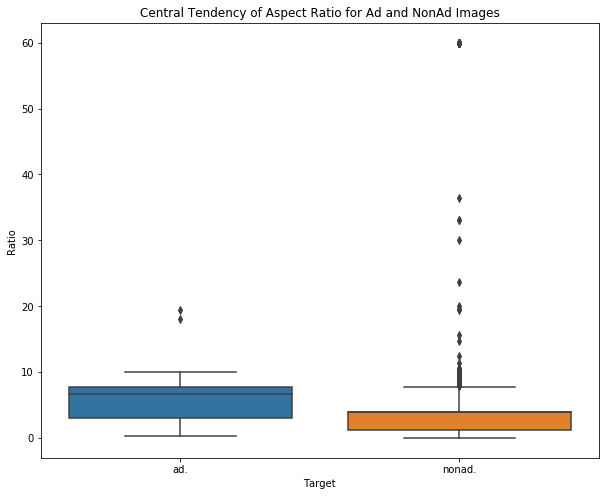

In [13]:
# Central Tendency of Ratio for each target (If the image is a perfect square is 1)
plt.figure(figsize=(10,8))
sns.boxplot(x = 'class',y = 'aratio', data = df)
plt.title('Central Tendency of Aspect Ratio for Ad and NonAd Images')
plt.xlabel('Target')
plt.ylabel('Ratio')

As for the aspect ratio, we do not see a distinct differences between the distribution for Ad and Non-ad images either but `aratio` does tend to be slightly smaller for nonads. 

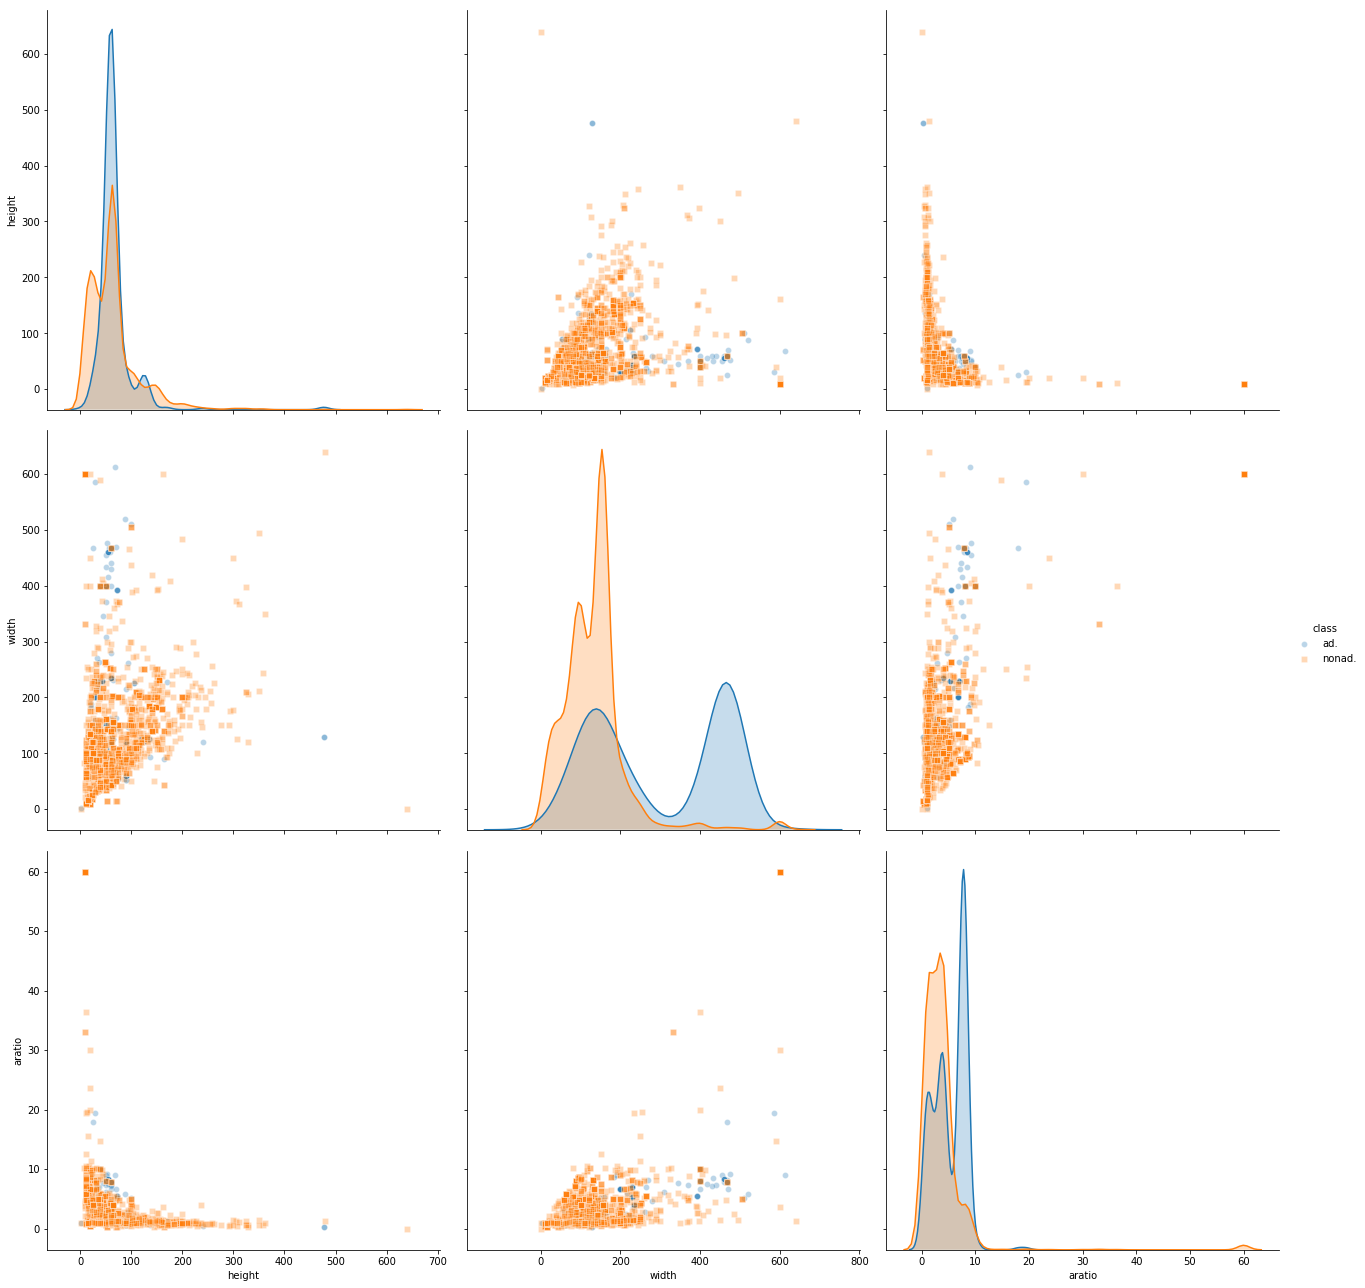

In [14]:
# let's see how variables relate to each other
sns.pairplot(data= df[['height', 'width','aratio','class']], hue = 'class', markers=["o", "s"], height = 6, plot_kws={'alpha':0.3})


We don't find any special relationship besides the positive relation between height and width that we would expect for both classes. 

We now look to further investigate the categorical variables in this dataset. In particular, we have many indicator variables for words or website addresses appearing in the url, original url, anchor url, alt and caption part of the image, e.g. `url*likesbooks.com`, `origurl*puc.edu`, `ancurl*www.slake.com`, `alt*your`, `caption*home`, etc. Here below we examine how prevalent each of these features is in Ad and Non-ad images.

Text(0, 0.5, 'Number of Urls')

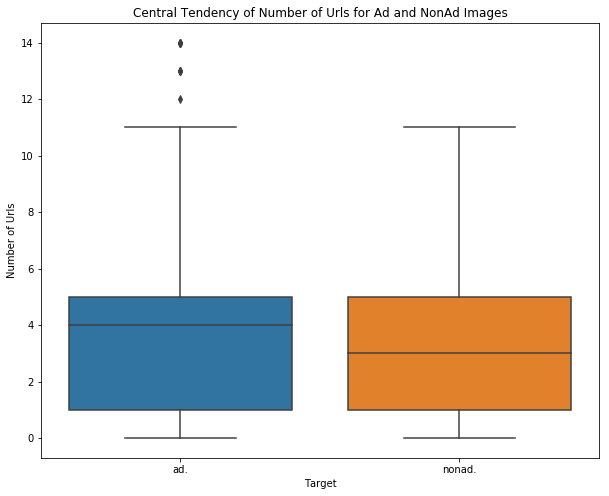

In [15]:
urls = df[list(filter(lambda x: x.startswith("url") or x == "class", names))]
num_urls = 457 - urls.eq(0).sum(axis=1)
urls.loc[:,'num_urls'] = num_urls

plt.figure(figsize=(10,8))
sns.boxplot(x = 'class',y = 'num_urls', data = urls)
plt.title('Central Tendency of Number of Urls for Ad and NonAd Images')
plt.xlabel('Target')
plt.ylabel('Number of Urls')

There are 457 different url related variables in the dataset. The boxplot above shows that the number of urls per image among ad and non-ad images has similar distributions. Below are lists of the top 10 most frequent values in the urls for ads and non-ads.

In [16]:
ad_urls = (urls.iloc[:, :458].groupby("class").sum())[:1].T
nonad_urls = (urls.iloc[:, :458].groupby("class").sum())[1:2].T

# top 10 urls for ad
ad_urls.loc[:, "percentage"] = ad_urls.apply(lambda row: row['ad.']/459*100, axis=1)
ad_urls.nlargest(10, "percentage")

class,ad.,percentage
url*ads,146,31.808279
url*images,130,28.322440
url*ad,49,10.675381
url*graphics,39,8.496732
url*ng,36,7.843137
url*image,35,7.625272
url*media,30,6.535948
url*ads+media,30,6.535948
url*geocities.com,30,6.535948
url*www.geocities.com,30,6.535948


In [17]:
# top 10 urls for non-ad
nonad_urls.loc[:, "percentage"] = nonad_urls.apply(lambda row: row['nonad.']/2820*100, axis=1)
nonad_urls.nlargest(10, "percentage")

class,nonad.,percentage
url*images,814,28.865248
url*geocities.com,551,19.539007
url*www.geocities.com,551,19.539007
url*images+geoguideii,189,6.702128
url*geoguideii,189,6.702128
url*heartland,171,6.063830
url*b+gif,130,4.609929
url*aol.com,89,3.156028
url*www.globec.com.au,88,3.120567
url*tkaine,88,3.120567


Even though the number of urls per image doesn't differ much between ad and non-ad images, the actual content of the url seems to spread less even among the two groups. Specifically, `url*ads` is the No.1 url indicator variables for ad images whereas the same indicator variable does not make the top 10 for non-ads. On the other hand, `url*images` is just as prevalent in ads and non-ads. We could use these information to do feature selection such that only url variables that have distinct differents are used for modeling.

Text(0, 0.5, 'Number of Origurls')

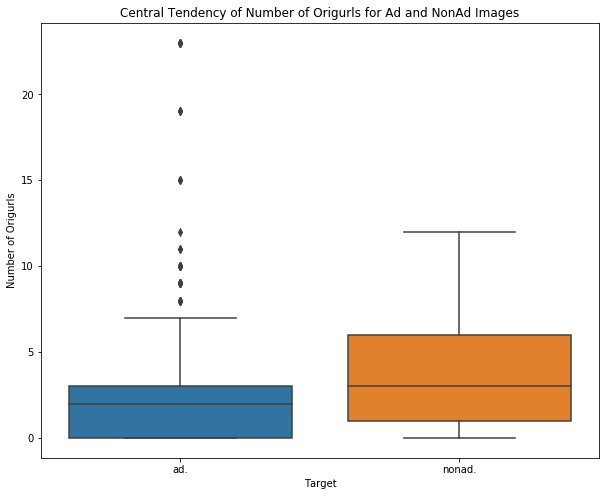

In [18]:
origurls = df[list(filter(lambda x: x.startswith("origurl") or x == "class", names))]
num_origurls = 495 - origurls.eq(0).sum(axis=1)
origurls.loc[:,'num_origurls'] = num_origurls

plt.figure(figsize=(10,8))
sns.boxplot(x = 'class',y = 'num_origurls', data = origurls)
plt.title('Central Tendency of Number of Origurls for Ad and NonAd Images')
plt.xlabel('Target')
plt.ylabel('Number of Origurls')

There are 495 unique origurl features. Comparing to the url variables analyzed above, the distributions for number of origurls per image do differ slightly between ad and non-ad images. However we do not see a clear separation of the boxplot ranges, thus the difference is not drastic enough to make classification determinations. 

In [19]:
ad_origurls = (origurls.iloc[:, :496].groupby("class").sum())[:1].T
nonad_origurls = (origurls.iloc[:, :496].groupby("class").sum())[1:2].T

# top 10 origurls for ad
ad_origurls.loc[:, "percentage"] = ad_origurls.apply(lambda row: row['ad.']/459*100, axis=1)
ad_origurls.nlargest(10, "percentage")

class,ad.,percentage
origurl*bin,36,7.843137
origurl*geocities.com,30,6.535948
origurl*www.geocities.com,30,6.535948
origurl*index,27,5.882353
origurl*search,23,5.010893
origurl*asp,22,4.793028
origurl*st,18,3.921569
origurl*news,18,3.921569
origurl*excite.com,18,3.921569
origurl*netscape.com,18,3.921569


In [20]:
# top 10 origurls for non-ad
nonad_origurls.loc[:, "percentage"] = nonad_origurls.apply(lambda row: row['nonad.']/2820*100, axis=1)
nonad_origurls.nlargest(10, "percentage")

class,nonad.,percentage
origurl*geocities.com,576,20.425532
origurl*www.geocities.com,576,20.425532
origurl*heartland,265,9.397163
origurl*index,229,8.120567
origurl*index+html,194,6.879433
origurl*valley,105,3.723404
origurl*heartland+valley,105,3.723404
origurl*aol.com,93,3.297872
origurl*www.globec.com.au,88,3.120567
origurl*tkaine,88,3.120567


Looking at the top 10 most frequent origurl variables for ads and non-ads, we see very litte overlaps. This is interesting because the contents of the orignal don't seem particularly indicative of ads and nonads on first glance. Next, we do the same analysis for anchor urls.

Text(0, 0.5, 'Number of Ancurls')

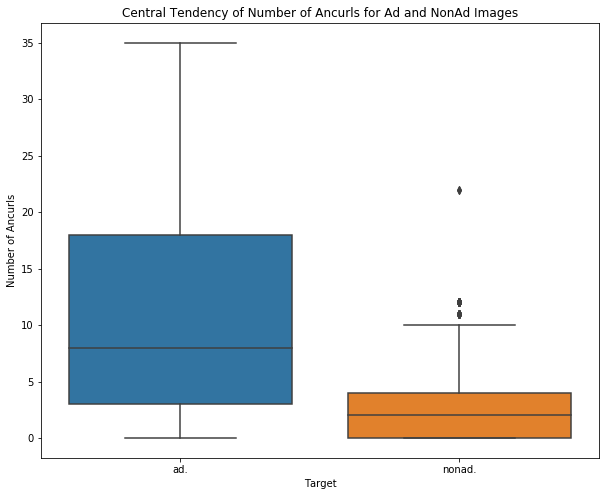

In [21]:
ancurls = df[list(filter(lambda x: x.startswith("ancurl") or x == "class", names))]
num_ancurls = 472 - ancurls.eq(0).sum(axis=1)
ancurls.loc[:,'num_ancurls'] = num_ancurls

plt.figure(figsize=(10,8))
sns.boxplot(x = 'class',y = 'num_ancurls', data = ancurls)
plt.title('Central Tendency of Number of Ancurls for Ad and NonAd Images')
plt.xlabel('Target')
plt.ylabel('Number of Ancurls')

There are 472 anchor url features in the dataset and here we do see a clear separation between the number of anchor urls per image between ad and non-ad images. It appears that the presence of more anchor text increases the likelihood that an image is an ad. Hence, we should try to add `num_ancurls` as an extra feature into the dataset for subsequent modeling.

In [22]:
ad_ancurls = (ancurls.iloc[:, :473].groupby("class").sum())[:1].T
nonad_ancurls = (ancurls.iloc[:, :473].groupby("class").sum())[1:2].T

# top 10 ancurls for ad
ad_ancurls.loc[:, "percentage"] = ad_ancurls.apply(lambda row: row['ad.']/459*100, axis=1)
ad_ancurls.nlargest(10, "percentage")

class,ad.,percentage
ancurl*com,189,41.176471
ancurl*bin,148,32.244009
ancurl*click,139,30.283224
ancurl*redirect,109,23.747277
ancurl*ng,101,22.004357
ancurl*adid,88,19.172113
ancurl*type,88,19.172113
ancurl*event,79,17.211329
ancurl*ng+type,78,16.993464
ancurl*runid,78,16.993464


In [23]:
# top 10 ancurls for non-ad
nonad_ancurls.loc[:, "percentage"] = nonad_ancurls.apply(lambda row: row['nonad.']/2820*100, axis=1)
nonad_ancurls.nlargest(10, "percentage")

class,nonad.,percentage
ancurl*geocities.com,489,17.340426
ancurl*www.geocities.com,469,16.631206
ancurl*bin,221,7.836879
ancurl*index,142,5.035461
ancurl*heartland,141,5.000000
ancurl*index+html,113,4.007092
ancurl*ring,88,3.120567
ancurl*webring,84,2.978723
ancurl*webring.org,82,2.907801
ancurl*bin+webring,81,2.872340


Once again we see slightly different frequent words in anchor urls for ad and non-ad images. In particular `ancurl*com` is very prevalent in ad images but does not make the top 10 for non-ads. Similarly, `ancurl*geocities.com` and `ancurl*www.geocities.com` rank highly for non-ads but are not in the top 10 for ads. We saw similar effects earlier for origurl features, but the difference here is more pronounced.

Text(0, 0.5, 'Number of Alts')

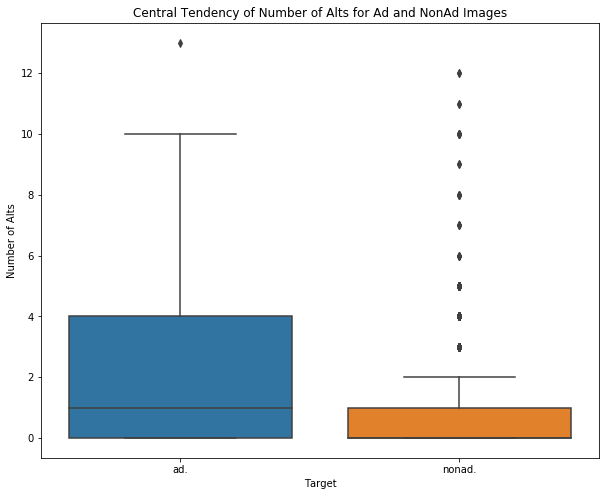

In [24]:
alts = df[list(filter(lambda x: x.startswith("alt") or x == "class", names))]
num_alts = 111 - alts.eq(0).sum(axis=1)
alts.loc[:,'num_alts'] = num_alts

plt.figure(figsize=(10,8))
sns.boxplot(x = 'class',y = 'num_alts', data = alts)
plt.title('Central Tendency of Number of Alts for Ad and NonAd Images')
plt.xlabel('Target')
plt.ylabel('Number of Alts')

There are 111 alt text features in the dataset. The spread of number of alt texts is wider for ad images than non-ad but there are a good amount of overlapping ranges. Hence this is not as clear an indicator as anchor urls but does invoke a bigger difference than urls or original urls.

In [25]:
ad_alts = (alts.iloc[:, :112].groupby("class").sum())[:1].T
nonad_alts = (alts.iloc[:, :112].groupby("class").sum())[1:2].T

# top 10 alts for ad
ad_alts.loc[:, "percentage"] = ad_alts.apply(lambda row: row['ad.']/459*100, axis=1)
ad_alts.nlargest(10, "percentage")

class,ad.,percentage
alt*click,134,29.193900
alt*here,124,27.015251
alt*click+here,123,26.797386
alt*for,75,16.339869
alt*here+for,53,11.546841
alt*the,39,8.496732
alt*to,33,7.189542
alt*and,23,5.010893
alt*free,22,4.793028
alt*com,21,4.575163


In [26]:
# top 10 alts for non-ad
nonad_alts.loc[:, "percentage"] = nonad_alts.apply(lambda row: row['nonad.']/2820*100, axis=1)
nonad_alts.nlargest(10, "percentage")

class,nonad.,percentage
alt*the,115,4.078014
alt*site,57,2.021277
alt*page,54,1.914894
alt*home,50,1.773050
alt*award,48,1.702128
alt*geocities,46,1.631206
alt*of,45,1.595745
alt*to,44,1.560284
alt*my,35,1.241135
alt*and,34,1.205674


As we have mentioned before, alt texts are in general less prevalent in non-ad images. Hence we are seeing very low percentages on all existing alt texts for the nonad entries.

In [27]:
captions = df[list(filter(lambda x: x.startswith("caption") or x == "class", names))]
num_captions = 19 - captions.eq(0).sum(axis=1)
num_captions.to_numpy().nonzero()[0].size

199

There are only 19 caption text features in the dataset and most of the images do not have any captions at all. In fact only 199 datapoints have any caption at all. Distributions and top values per label are not constructed due to the limited datapoints. This could also mean that we can consider dropping all caption related variables as part of the feature engineering.

This concludes our data analysis and a summary of interesting observations are reiterated below:
- We have an uneven split between datapoints for ads and non-ads in our dataset. In particular we have 2820 non-ad images and 459 ad images.
- `width` and `num_ancurls` have distinctly different distributions among ad and non-ad images, which makes them effective predicting variables for modeling.
- `num_alts` and specific url/origurl address can potentially be used as weak indicators for ads and non-ads since they are slightly more prevalent in a particular label.
- Certain url/origurl addresses and captions can potentially be ignored because they are either distributed similar across the two labels or simply not present for most of the dataset.

## Model Selection & Evaluation

We now proceed with buidling models based on our dataset to hopefully predict effectively whether or not an image is an ad or not. First we split our dataset into 3 sets, namely training set, dev set, and test set. This is so that we can be more confident at our models and to better compare the model options we come up with. Specifically, training set is used to train our models, dev set is used to optimize each model, and test set is used to evaluate performance of the model. We have assigned 20% of the total dataset to be the test set, and then 20% of the remining 80% (in other words 16% of the total dataset) to be the dev set, and the rest being training set.

In [28]:
# define X and y for attributes and prediction - the last column is the label of the data point
X = df.iloc[:,1:-1]
X = X.fillna(-1)
y = df.iloc[:,-1]

# we add num_ancurls into the attributes
ancurls = df[list(filter(lambda x: x.startswith("ancurl"), names))]
num_ancurls = 472 - ancurls.eq(0).sum(axis=1)
X.loc[:, "num_ancurls"] = num_ancurls

print('data shape:', X.shape)
print('label shape:', y.shape)

data shape: (3279, 1558)
label shape: (3279,)


In [29]:
# set some variables to hold train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# split again into train and dev
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size = 0.2)

### Model Building

#### K-Nearest Neighbors 

We first use the K-Nearest Neighbors algorithm. This algorithm predicts the class of each observation by finding the number K nearest neighbors and assigning the class the majority of the neighbors belong to.

We optimize the hyperparameters according to the number of neighbors, whether to use uniform or distance-based weights for evaluating which class an observation belongs to, and the "power" of the distance measurement.

K-Nearest Neighbors works poorly in high dimensions. In the case of this Internet advertisements dataset with a large number of dimensions, we anticipate bad performance.

In spite of the prediction of bad performance, the weighted f1-score is still high, at 0.96.

In [30]:
# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# KNN
# Input different values for hyperparameters
parameters = {'n_neighbors': [1, 3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]}

knn = KNeighborsClassifier()
    
# find the best hyperparameters
clf = GridSearchCV(knn, parameters)
clf.fit(X_train, y_train)

predictions = clf.predict(X_dev)

print("Classification report for best KNN")
print("Hyperparameters used: {}".format(clf.best_params_))
print(classification_report(y_dev, predictions))

Classification report for best KNN
Hyperparameters used: {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

         ad.       0.94      0.82      0.88        82
      nonad.       0.97      0.99      0.98       443

    accuracy                           0.96       525
   macro avg       0.96      0.90      0.93       525
weighted avg       0.96      0.96      0.96       525



#### Support Vector Machine

The support vector machine algorithm seeks to divide observations of different classes with as large a space as possible when these observations have been assigned as points to the feature space.

We optimize the hyperparameter "C" which is the penalty parameter of the error term.

After optimization, the best support vector machine classifier has a weighted f1-score of 0.97, which is better than the K-nearest neighbors algorithm performance.

In [31]:
# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# Support Vector Machine
parameters = {"C": [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000]}

svm = SVC()

# find the best hyperparameters
clf = GridSearchCV(svm, parameters)
clf.fit(X_train, y_train)

predictions = clf.predict(X_dev)

print("Classification report for support vector machine")
print("Hyperparameters used: {}".format(clf.best_params_))
print(classification_report(y_dev, predictions))

Classification report for support vector machine
Hyperparameters used: {'C': 1000}
              precision    recall  f1-score   support

         ad.       0.95      0.85      0.90        82
      nonad.       0.97      0.99      0.98       443

    accuracy                           0.97       525
   macro avg       0.96      0.92      0.94       525
weighted avg       0.97      0.97      0.97       525



#### Logistic Regression

Logistic regression estimates regression parameters for the logistic function, and is used in this case to predict classes for the observations in the development and test datasets.

The hyperparameter we optimize in this investigation for this algorithm is "C", the regularization strength which penalizes having too many features in the model.

In general, logistic regression performs better when there are more observations.

After optimizing, the best logistic regression model found has a weighted f1-score of 0.97.

In [32]:
# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# Logistic regression
parameters = {"C": [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000]}

lr = LogisticRegression(penalty="l2", solver = "liblinear")

# find the best hyperparameters
clf = GridSearchCV(lr, parameters)
clf.fit(X_train, y_train)

predictions = clf.predict(X_dev)

print("Classification report for logistic regression")
print("Hyperparameters used: {}".format(clf.best_params_))
print(classification_report(y_dev, predictions))

Classification report for logistic regression
Hyperparameters used: {'C': 10}
              precision    recall  f1-score   support

         ad.       0.95      0.85      0.90        82
      nonad.       0.97      0.99      0.98       443

    accuracy                           0.97       525
   macro avg       0.96      0.92      0.94       525
weighted avg       0.97      0.97      0.97       525



#### Bernoulli Naive Bayes

The Bernoulli Naive Bayes classifier applies Bayes' Rule to classification, with strong independence assumptions between features. This assumption may not be appropriate for the features seen in this dataset, as the features may be correlated with each other. This particular classifier is the Bernoulli algorithm, so it treats each feature as a binary variable.

We optimize the "alpha" hyperparameter, which is the Laplace smoothing parameter.

On the development data set, the weighted f1-score is 0.96.

In [33]:
# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# Bernoulli Naive Bayes
parameters = {"alpha": [0.001, 0.01, 0.1, 0.5, 1, 10]}

bnb = BernoulliNB()

# find the best hyperparameters
clf = GridSearchCV(bnb, parameters)
clf.fit(X_train, y_train)

predictions = clf.predict(X_dev)

print("Classification report for Bernoulli Naive Bayes")
print("Hyperparameters used: {}".format(clf.best_params_))
print(classification_report(y_dev, predictions))

Classification report for Bernoulli Naive Bayes
Hyperparameters used: {'alpha': 0.01}
              precision    recall  f1-score   support

         ad.       0.98      0.74      0.85        82
      nonad.       0.95      1.00      0.98       443

    accuracy                           0.96       525
   macro avg       0.97      0.87      0.91       525
weighted avg       0.96      0.96      0.96       525



#### Multinomial Naive Bayes

The multinomial Naive Bayes works with the same principles as the Bernoulli Naive Bayes model above; however, variables are treated not just as binary variables.

Like the above Bernoulli Naive Bayes method, we optimize the "alpha" hyperparameter.

The weighted f1-score for the optimized algorithm is 0.95.

In [34]:
# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# Multinomial Naive Bayes
parameters = {"alpha": [0.001, 0.01, 0.1, 0.5, 1, 10]}

mnb = MultinomialNB()

# find the best hyperparameters
clf = GridSearchCV(mnb, parameters)
clf.fit(X_train, y_train)

predictions = clf.predict(X_dev)

print("Classification report for Multinomial Naive Bayes")
print("Hyperparameters used: {}".format(clf.best_params_))
print(classification_report(y_dev, predictions))

Classification report for Multinomial Naive Bayes
Hyperparameters used: {'alpha': 0.5}
              precision    recall  f1-score   support

         ad.       0.87      0.79      0.83        82
      nonad.       0.96      0.98      0.97       443

    accuracy                           0.95       525
   macro avg       0.91      0.89      0.90       525
weighted avg       0.95      0.95      0.95       525



#### Decision Tree

The decision tree algorithm can be thought of as a series of decisions, branching off in a treelike way. It uses features to make a decision for each observation and at the end of the tree assigns each to a class.

In our optimization, we find the best hyperparameters for the depth of the tree, the minimum number of samples per split and leaf, and the maximum number of features considered.

The decision tree has a tendency to overfit and can be computationally intensive to fit.

The best decision tree is found to have a weighted f1-score of 0.96.

In [35]:
# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# Decision Tree
# Input different values for hyperparameters
parameters = {'max_depth': [5, 10, 100, 1000, 10000, 100000, None], 
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9], 
              'min_samples_leaf': [1, 2, 3],
              'max_features': [None, 'auto', 'sqrt', 'log2']}

dt = DecisionTreeClassifier()
    
# find the best hyperparameters
clf = GridSearchCV(dt, parameters)
clf.fit(X_train, y_train)

predictions = clf.predict(X_dev)

print("Classification report for best decision tree")
print("Hyperparameters used: {}".format(clf.best_params_))
print(classification_report(y_dev, predictions))

Classification report for best decision tree
Hyperparameters used: {'max_depth': 1000, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

         ad.       0.90      0.85      0.88        82
      nonad.       0.97      0.98      0.98       443

    accuracy                           0.96       525
   macro avg       0.94      0.92      0.93       525
weighted avg       0.96      0.96      0.96       525



#### Random Forest

The random forest algorithm is an ensemble method made of many decision trees. Each decision tree has a subset of the total number of features, and the decision trees "vote" to predict the class of new observations.

In this study we optimize the hyperparameters number of estimators, the minimum number of samples per leaf, and the maximum depth of each estimator.

One of the motivations behind the random forest algorithm is that it can compensate for the overfitting seen in the decision tree algorithm.

We find that the weighted f1-score is 0.98 for the train data.

In [36]:
# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# Random Forest
parameters = {'n_estimators': [5, 15, 25, 35, 45],
              'min_samples_leaf': [1, 2, 3],
              'max_depth': [10, 75, 100, 150, 1000]}

rf = RandomForestClassifier(n_jobs=-1)

# find the best hyperparameters
clf = GridSearchCV(rf, parameters)
clf.fit(X_train, y_train)

predictions = clf.predict(X_dev)

print("Classification report for random forest")
print("Hyperparameters used: {}".format(clf.best_params_))
print(classification_report(y_dev, predictions))

Classification report for random forest
Hyperparameters used: {'max_depth': 1000, 'min_samples_leaf': 1, 'n_estimators': 35}
              precision    recall  f1-score   support

         ad.       0.97      0.88      0.92        82
      nonad.       0.98      1.00      0.99       443

    accuracy                           0.98       525
   macro avg       0.98      0.94      0.95       525
weighted avg       0.98      0.98      0.98       525



#### Bagged Tree

Like the random forest method, the bagged tree method is an ensemble method that combines the results of many different decision tree estimators. The difference with random forest is that this algorithm uses all the features, but only a sample of the entire training data set to do its training for each decision tree.

The hyperparameter optimized for bagged tree is the number of estimators.

Like the random forest method, the bagged tree method can compensate for the overfitting that can happen in the decision tree algorithm.

We found that the weighted f1-score for the optimized bagged tree model is 0.97.

In [37]:
# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# Bagged Tree
parameters = {'n_estimators': [5, 15, 25, 35, 45]}

bt = BaggingClassifier()

# find the best hyperparameters
clf = GridSearchCV(bt, parameters)
clf.fit(X_train, y_train)

predictions = clf.predict(X_dev)

print("Classification report for bagged tree")
print("Hyperparameters used: {}".format(clf.best_params_))
print(classification_report(y_dev, predictions))

Classification report for bagged tree
Hyperparameters used: {'n_estimators': 15}
              precision    recall  f1-score   support

         ad.       0.95      0.89      0.92        82
      nonad.       0.98      0.99      0.99       443

    accuracy                           0.98       525
   macro avg       0.96      0.94      0.95       525
weighted avg       0.97      0.98      0.97       525



#### Most Important Features for Optimized Bagged Tree

For the best bagged tree classifier after hyperparameter tuning, we examine the most important features.

We get the average of the feature importances (Gini importances) for the trees in the bagged tree classifier.

The first two features have a higher importance measure by a large margin. They are `width` and the number of anchor URLs, which were anticipated as being important features in the Data Analysis section above.

The `url*ads` and `url*ad` features are also anticipated as being important in the earlier section, appearing in the most frequently appearing url features lists only for the ad class.

Other important features are if "com" or "click" appear in the anchor URL.

In [38]:
# find the average feature importances and find the top 10 average importances
feature_importances = np.mean([
    tree.feature_importances_ for tree in clf.best_estimator_.estimators_
], axis=0)
top_10_features = sorted(feature_importances, reverse=True)[:10]

# print out the top 10 average importances
print("{:5s}{:20s}{}".format("Rank", "Feature Name", "Gini Importance"))
for i, importance in enumerate(top_10_features):
    print("{:5s}{:20s}{:.3f}".format(str(i+1), X_dev.columns[list(feature_importances).index(importance)], importance))

Rank Feature Name        Gini Importance
1    width               0.299
2    num_ancurls         0.252
3    url*ads             0.058
4    ancurl*click        0.052
5    ancurl*com          0.051
6    ancurl*http+www     0.042
7    aratio              0.024
8    url*ad              0.015
9    ancurl*area         0.010
10   url*images+home     0.008


#### Misclassified Records for Optimized Bagged Tree

From the holdout set kept for model development purposes there were a few observations that were misclassified by the optimized bagged tree.

Out of the misclassified observations, most were ads that were misclassified as non-ads. This might have something to do with the unbalanced nature of the training dataset with more non-ads than ads, making it more likely for ads in the development dataset to be misclassified as non-ads.

There are a few reasons why these may have been put into the wrong class. Many of the ad observations have unusually small widths and few or no anchor URLs, which may have made the algorithm misclassify them as non-ads.

For the non-ads classified as ads, they tend to have many anchor URLs and large widths; this may have led to them being classified incorrectly as ads.

In [39]:
# misclassified records
pd.concat([y_dev[y_dev != predictions], X_dev[y_dev != predictions]], axis=1)

,class,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,num_ancurls
105,ad.,58.000000,2.900000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
372,ad.,400.000000,10.000000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1009,nonad.,400.000000,20.000000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
377,ad.,345.000000,7.666600,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99,ad.,54.000000,0.729700,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
492,nonad.,58.000000,1.160000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
100,ad.,96.000000,3.096700,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
369,ad.,400.000000,10.000000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1211,nonad.,88.000000,2.838700,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
437,ad.,155.344828,3.911953,1.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2


In [40]:
# look at the most important features for the misclassified observations
pd.concat([y_dev[y_dev != predictions], X_dev[y_dev != predictions]], axis=1)[["class", 
                                                                               "width", 
                                                                               "aratio", 
                                                                               "num_ancurls",
                                                                               "url*ads",
                                                                               "url*ad",
                                                                               "url*images+home",
                                                                               "ancurl*com",
                                                                               "ancurl*click",
                                                                               "ancurl*http+www",
                                                                               "alt*click+here"]]

,class,width,aratio,num_ancurls,url*ads,url*ad,url*images+home,ancurl*com,ancurl*click,ancurl*http+www,alt*click+here
105,ad.,58.000000,2.900000,1,0,0,0,0,0,0,0
372,ad.,400.000000,10.000000,0,0,0,0,0,0,0,0
1009,nonad.,400.000000,20.000000,4,0,0,0,1,0,0,0
377,ad.,345.000000,7.666600,0,0,0,0,0,0,0,0
99,ad.,54.000000,0.729700,0,0,0,0,0,0,0,0
492,nonad.,58.000000,1.160000,3,0,0,0,0,0,0,0
100,ad.,96.000000,3.096700,0,0,0,0,0,0,0,0
369,ad.,400.000000,10.000000,0,0,0,0,0,0,0,0
1211,nonad.,88.000000,2.838700,3,0,0,0,0,0,0,0
437,ad.,155.344828,3.911953,2,0,0,0,0,0,0,0


#### Final Optimized Models

By utilizing the dev set, we optimized parameters using `GridSearchCV` for all the models above. Here below is the finalized models with the best parameter reported.

In [41]:
# Final Optimized Models
knn_opt = KNeighborsClassifier(n_neighbors = 1, p = 1, weights = "uniform")
svm_opt = SVC(C = 1000)
lr_opt = LogisticRegression(penalty="l2", solver = "liblinear", C = 10)
bnb_opt = BernoulliNB(alpha = 0.01)
mnb_opt = MultinomialNB(alpha = 0.5)
dt_opt = DecisionTreeClassifier(max_depth = 1000, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2)
rf_opt = RandomForestClassifier(max_depth = 1000, min_samples_leaf = 1, n_estimators = 35, n_jobs=-1)
bt_opt = BaggingClassifier(n_estimators = 15)

### Model Evaluation

To evaluate models we use Holdout and K-Fold Cross-Validation. Holdout is useful because of its speed, simplicity and flexibility; however it is often associated with high variability since differences in the training and test set can result in meaninful difference in the estimate of accuracy; that's why we would also implement Cross-Validation and compare the results.

#### Holdout

  Model   Accuracy
6    RF  98.780488
7    BT  98.323171
2    LR  97.560976
3   BNB  97.560976
0   KNN  97.256098
1   SVC  96.798780
4   MNB  96.341463
5    DT  95.731707


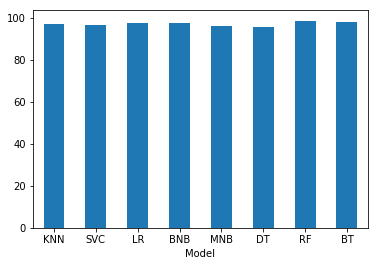

In [42]:
models = [['KNN', knn_opt],
          ['SVC', svm_opt],
          ['LR', lr_opt],
          ['BNB', bnb_opt],
          ['MNB', mnb_opt],
          ['DT',dt_opt],
          ['RF',rf_opt],
          ['BT', bt_opt]] 

table = []
for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    table.append((name,100*accuracy))
    
df = pd.DataFrame(table, columns =['Model', 'Accuracy'])
plot = df.plot.bar(x='Model', y='Accuracy', rot=0, legend = None)
df = df.sort_values(by=['Accuracy'],ascending=False)
print(df)
        

After using Holdout, the models that returned the highest accuracy were Random Forest, Bagged Tree and Logistic Regression.

#### Cross-Validation (K-Fold)

  Model   Accuracy
3   BNB  95.426643
7    BT  95.273924
6    RF  93.993623
4   MNB  93.871299
1   SVC  93.413422
2    LR  93.200753
5    DT  92.286212
0   KNN  91.615108


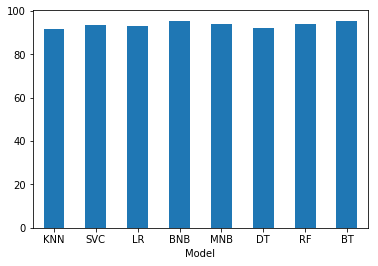

In [43]:
seed = 7
models = [['KNN', knn_opt],
          ['SVC', svm_opt],
          ['LR', lr_opt],
          ['BNB', bnb_opt],
          ['MNB', mnb_opt],
          ['DT',dt_opt],
          ['RF',rf_opt],
          ['BT', bt_opt]] 

table = []
for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = seed)
    clf = model
    accuracy = model_selection.cross_val_score(clf, X, y, cv = kfold, scoring = 'accuracy')
    table.append((name,100*(accuracy.mean())))
    
df = pd.DataFrame(table, columns =['Model', 'Accuracy'])
plot = df.plot.bar(x='Model', y='Accuracy', rot=0, legend = None)
df = df.sort_values(by=['Accuracy'],ascending=False)
print(df)

With K-fold, the accuracies were lower overall and the models that returned the highest accuracy were Bernoulli Naive Bayes, Bagged Tree and Random Forest.

## Summary

The goal of this project is to develop a model that can be effective at classifying Internet images as ad or non-ad given a series of attributes. The dataset we used contains 3,279 data points and 1,559 features where 2,820 are labeled as non-ads and 459 are ads. After conducting data analysis on the continuous and categorical variables in the data, we found that variable `width` and the number of anchor urls a particular image has are strongly correlated to an image being ad. Discoveries such as this one helped us to enhance the set of features we then used for model building.

Several algorithms were examined to solve this classification problem. In particular, we built models using K-Nearest Neighbors, Support Vector Machine, Logistic Regression, Bernoulli Naive Bayes, Multinomial Naive Bayes, Decision Tree, Random Forest, and Bagged Tree. Each model was optimized through hyperparameter tunning using `GridSearchCV`. The finalized models were then evaluated aginst each other. Both Holdout and K-fold validation methods were used to decide which of the models we built performs the best. Random Forest yielded the highest accuracy against our test dataset while Bernoulli Naive Bayes performed the best in K-fold. Bagged Tree model is the one that had the second highest accuracies in both validation methods. Hence, overall we would pick the Bagged Tree model as the final classifier.

Even though we achieved over 90% accuracies with our models, there are still many aspects we could improve upon. For instance, we could have more aggressively selected the set of features used. Our data analysis step helped us to figure out what other composition features may be needed. But at the same time, it also revealed features that may not be very useful in determining ads. For example, very few data points have any caption at all. For simplicity of the model we could have dropped unaffecting variables early on. Additionally, we could have analyzed the misclassified cases further to see if we can find any patterns or reasons to why certain images are not correctly identified. 

Despite these imperfections, we were successful at developing an effective classifier model for internet images. The final optimized Bagged Tree model could be used both in web and potentially in mail and messaging clients as well to block unwanted advertisement and promote a better browsing experience.

### Contributions

Kudos to everyone on the team for collaborating so wonderfully on this project! Here is a short breakdown of individual contributions to the project.

Maria:
- dataset pitching
- data cleaning and EDA for the label and continuous features in the chosen dataset
- model evaluations and comparisons

Dean:
- dataset pitching
- model building and optimization

Angel:
- dataset pitching
- EDA for categorical features in the chosen dataset
- model optimization
- overall notebook structure, section transition, introduction and summary